<a href="https://colab.research.google.com/github/mchivuku/csb659-project/blob/master/Learning_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Learning VAE

In [0]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive/Masters-DS/CSCI-B659/project/vae-model1

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Masters-DS/CSCI-B659/project/vae-model1


In [0]:
%%capture
!pip install tqdm six


## Load Libraries

In [0]:
from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import shutil
from torchvision import transforms
from torchvision import models
import torchvision
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.optim import lr_scheduler
from torch import optim
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import time
from torchvision import datasets,transforms
import torch.nn.functional as F
import torch.optim as optim


import os
from torchvision.utils import save_image

## Plotting library

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import cv2
from scipy.stats import norm
from sklearn import manifold

plt.style.use('fivethirtyeight')
%matplotlib inline

print('Torch', torch.__version__, 'CUDA', torch.version.cuda)
print('Device:', torch.device('cuda:0'))
print(torch.cuda.is_available())

is_cuda = torch.cuda.is_available()
device = torch.device ( "cuda:0" if torch.cuda.is_available () else "cpu" )

Torch 1.0.1.post2 CUDA 10.0.130
Device: cuda:0
True


## Some Utilities - to visualize


In [0]:
## Show image
def imshow(img,title=None):
  """Imshow for Tensor."""
  img = img.numpy().transpose((1,2,0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  img = std * img + mean # normalize
  img = np.clip(img, 0, 1) # clip image
  plt.figure(figsize=(16,4))
  plt.axis('off')
  plt.imshow(img)
  
  if title is not None:
    plt.title(title)         
  
def plot_grid(inputs):
  # Make a grid from batch 
  out = torchvision.utils.make_grid(inputs,10,10)
  imshow(out, title="")

## Metric

In [0]:
### Metrics - Base Class For all Metrics
class Metric:
  def __init__(self):
    pass
  def __call__(self, outputs, target, loss):
    raise NotImplementedError
    
  def reset(self):
    raise NotImplementedError
    
  def value(self):
    raise NotImplementedError
    
  def name(self):
    raise NotImplementedError
    
## Accuracy Metric
class AccumulatedAccuracyMetric(Metric):
  def __init__(self):
      self.correct = 0
      self.total = 0
      
  def __call__(self, outputs, target):
      # Track the accuracy
      _, argmax = torch.max(outputs, 1)
      accuracy = (target == argmax.squeeze()).float().sum()
      self.correct += accuracy 
      self.total += target.size(0)
      return self.value()
  
  def reset(self):
      self.correct = 0
      self.total = 0

  def value(self):
      return 100 * float(self.correct) / self.total

  def name(self):
      return 'Accuracy'
    
    
## Loss
class RunningAverage ():
    """A simple class that maintains the running average of a quantity
    Example:
    ```
    loss_avg = RunningAverage()
    loss_avg.update(2)
    loss_avg.update(4)
    loss_avg() = 3
    ```
    """

    def __init__( self ):
        self.steps = 0
        self.total = 0

    def update( self, val ):
        self.total += val
        self.steps += 1

    def __call__( self ):
        return self.total / float ( self.steps )
      
      
      
"""
Directory to store results

"""
      
def make_results(dir):
  if os.path.isdir(dir):
    shutil.rmtree(dir)
  os.makedirs(dir)
  

## Load Data

In [0]:
path="/content/drive/My Drive/Masters-DS/Deep Learning - E533/Homework3/"

transformation = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST(os.path.join(path,"MNIST/data"),train=True,transform=transformation,download=True)
test_dataset = datasets.MNIST(os.path.join(path,"MNIST/data"),train=False,transform=transformation,download=True)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=128,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=128,shuffle=True)

## Test TSNE plot for reconstrunction on 1000 test samples
testing_tsne = torch.utils.data.DataLoader(train_dataset,batch_size=len(train_dataset),shuffle=True)
test_data, test_labels = next(iter(testing_tsne))[:1000]

In [0]:
print(f"Total number of train images: {len(train_dataset)}, total number of test images: {len(test_dataset)}, total number of train batches: {len(train_loader)}")

Total number of train images: 60000, total number of test images: 10000, total number of train batches: 469


## Models

### Encoder Network

In [0]:
class Encoder(nn.Module):
  def __init__(self, nb_latents):
    super(Encoder,self).__init__()
    
    ## Netwrok
    self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
    self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        
    self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
    self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=2, stride=1),
            nn.ReLU())
        
    self.fc1 = nn.Linear(1024, 256)
        
    self.fc_mean = nn.Linear(256, nb_latents)
    self.fc_std = nn.Linear(256, nb_latents)
    
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()
    
  def forward(self,x):
    x = (self.conv1(x))
    x =  (self.conv2(x))
    x =  (self.conv3(x))
    x =  (self.conv4(x))
    x = x.reshape(x.size(0), -1)
    x = self.relu(self.fc1(x))
    return self.fc_mean(x), self.fc_std(x)
  
  

### Decoder

In [0]:
class Decoder(nn.Module):
  def __init__(self,nb_latents):
    super(Decoder, self).__init__()
    
    self.fc1 = nn.Linear(nb_latents, 256)
    self.fc2 = nn.Linear(256, 1024)
        
        
        
    self.fc3 = nn.Linear(1024,7*7*64)
        
    self.deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
    self.deconv2 = nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2)
    
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()
    
  def forward(self, z):
    x = self.relu(self.fc1(z))
    x = self.relu(self.fc2(x))
    x = self.relu(self.fc3(x))
    x = self.relu(self.deconv1(x.view(-1, 64, 7, 7)))
    x = self.deconv2(x)
    return self.sigmoid(x)
  
 
    
    

### Classifier

In [0]:
class Classifier(nn.Module):
  def __init__(self,nb_latents):
    super(Classifier,self).__init__()
    
    ## Define NN - 5 hidden layers 1024 hidden units
    self.fc1 = nn.Linear(nb_latents, 1024)
    self.fc2 = nn.Linear(1024, 1024)
    self.fc3 = nn.Linear(1024, 10)
    
  
  def forward(self,x):
    ## flat input features
    x = x.view(-1, self.num_flat_features(x))
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
   
    
    x = self.fc3(x)
    
    return F.log_softmax(x, dim=1)  
  
  def num_flat_features(self,x):
    size = x.size()[1:] # all dimensions except the batch dimension
    num_features = 1
    for s in size:
      num_features *=s
    return num_features

### VAE Network

In [0]:
class VAE(nn.Module):
  def __init__(self,nb_latents):
    super(VAE,self).__init__()
    
    self.encoder = Encoder(nb_latents)
    self.decoder = Decoder(nb_latents)
    
    ## Classifier
    #self.classifier = Classifier()
   
  def reparameterize(self, mu, logvar):
    std = logvar.mul(0.5).exp_()
    eps = Variable(std.data.new(std.size()).normal_())
    return eps.mul(std).add_(mu)
    
  def forward(self, x):
    mu, logvar = self.encoder(x)
    z = self.reparameterize(mu, logvar)
    return self.decoder(z), mu, logvar
  
  
  def encode(self,x):
    mu, logvar = self.encoder(x)
    return mu, logvar
    
  def decode(self,x):
    return self.decoder(x)
    
  
    

In [0]:
### Loss Function
def loss_function(recon_x, x, mu, logvar,beta=1):
  """
  Reconstruction loss  + KL divergence loss over all elements of the batch
  """
  bce = F.binary_cross_entropy(recon_x, x.view(-1, 28*28), size_average=False)
  
  kld = -0.5* (1+ logvar -mu.pow(2) -  logvar.exp())
  return kld.mean(dim = 0), bce + beta*kld.sum()

In [0]:
nb_latents = 20
model = VAE(nb_latents)
if is_cuda:
  model = model.to(device)

print(model)

optimizer = optim.Adam(model.parameters(), lr=1e-3)



VAE(
  (encoder): Encoder(
    (conv1): Sequential(
      (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv3): Sequential(
      (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv4): Sequential(
      (0): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1))
      (1): ReLU()
    )
    (fc1): Linear(in_features=1024, out_features=256, bias=True)
    (fc_mean): Linear(in_features=256, out_features=20, bias=True)
    (fc_std): Linear(in_features=256, out_features=20, bias=True)
    (relu): ReLU()
    (sig

## Traverse Latent Space

In [0]:
import os
#os.makedirs("traverse")
 

"""
Traverse Latents
"""
def traverse_latents(model, datapoint, nb_latents, epoch, batch_idx, dirpath="traverse"):
  model.eval()
  datapoint = datapoint.to(device)
  if isinstance(model,VAE):
    datapoint = datapoint.unsqueeze(0)
    mu, _ = model.encode(datapoint)
  else:
    mu, _ = model.encode(datapoint.view(-1))
  
  recons = torch.zeros((7, nb_latents, 28, 28))
  for zi in range(nb_latents):
    muc = mu.squeeze().clone()
    for i, val in enumerate(np.linspace(-3, 3, 7)):
      muc[zi] = val
      
      recon = model.decode(muc).cpu()
      recons[i, zi] = recon.view(28, 28)

  filename = os.path.join(dirpath, 'traversal_' + str(epoch) + '_' + str(batch_idx) + '.png')
  save_image(recons.view(-1, 1, 28, 28), filename, nrow=nb_latents, pad_value=1)

## Train Epoch

In [0]:
log_interval = 1
save_interval = 1
testpoint = torch.Tensor(train_loader.dataset[0][0]).to(device)
def train_epoch(epoch):
  model.train()
  
  for batch_idx, (data, labels) in enumerate(train_loader):
    data = data.to(device)
    labels = labels.to(device)
    
    
    batch_size = data.size(0)

    recon_batch, mu, logvar = model(data)
    
    kld, loss = loss_function(recon_batch.squeeze().view(-1,28*28), data, mu, logvar)
    ## parameter update
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
      
    
    
    loss /=len(data)
    
    if not batch_idx % log_interval:
      print("Epoch {}, batch: {}/{}, loss: {:.2f}".format(
              epoch, batch_idx, len(train_loader), loss))
      
    if not batch_idx % save_interval:
      traverse_latents(model, testpoint, nb_latents, epoch, batch_idx)
      model.train()

In [0]:
## Test Epoch
"""
Test
"""
def test_epoch(epoch):
    model.eval()
    test_loss = RunningAverage()
    
    ## Test reconstruction test
    testpoint = torch.Tensor(test_loader.dataset[0][0]).to(device)
  
    with torch.no_grad():
        for i, (data,labels) in enumerate(test_loader):
            data = data.to(device)
             
            batch_size = data.size(0)
            recon_batch, mu, logvar = model(data)
            
            ## Loss of VAE
            kld, loss = loss_function(recon_batch.squeeze().view(-1,28*28), data, mu, logvar)
            
            test_loss.update(loss.item() / len(data))
            
            if i % 200 == 0:
              ## test reconstruction
              n = min(data.size(0), 8)
              comparison = torch.cat([data[:n],recon_batch[:n]])
              save_image(comparison.cpu(),'./traverse/test_reconstruction_' + str(epoch) + '.png', nrow=n)
    
   
    return test_loss()


In [0]:
test_losses = []
for epoch in range(20):
  train_epoch(epoch)
  test_loss = test_epoch(epoch)
  message = 'Epoch: {}/{}. Test set: Average loss: {:.4f}'.format(epoch + 1, 20, test_loss)
  test_losses.append(test_loss)
  
  
  # Generate samples of reconstruction
  with torch.no_grad():
    sample = torch.randn(64, nb_latents).to(device)
    sample = model.decode(sample).cpu()
    save_image(sample.view(64, 1, 28, 28),
             'traverse/sample_' + str(epoch) + '.png')  
  
  

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0, batch: 0/469, loss: 531.84
Epoch 0, batch: 1/469, loss: 516.91
Epoch 0, batch: 2/469, loss: 500.65
Epoch 0, batch: 3/469, loss: 479.07
Epoch 0, batch: 4/469, loss: 446.33
Epoch 0, batch: 5/469, loss: 396.92
Epoch 0, batch: 6/469, loss: 322.94
Epoch 0, batch: 7/469, loss: 184.02
Epoch 0, batch: 8/469, loss: -82.04
Epoch 0, batch: 9/469, loss: -718.85
Epoch 0, batch: 10/469, loss: 19604.12
Epoch 0, batch: 11/469, loss: -1875.36
Epoch 0, batch: 12/469, loss: -1667.84
Epoch 0, batch: 13/469, loss: -1410.67
Epoch 0, batch: 14/469, loss: -1329.75
Epoch 0, batch: 15/469, loss: -1339.09
Epoch 0, batch: 16/469, loss: -1520.76
Epoch 0, batch: 17/469, loss: -1483.04
Epoch 0, batch: 18/469, loss: -1653.77
Epoch 0, batch: 19/469, loss: -1896.60
Epoch 0, batch: 20/469, loss: -1994.61
Epoch 0, batch: 21/469, loss: -2394.48
Epoch 0, batch: 22/469, loss: -2794.45
Epoch 0, batch: 23/469, loss: -3179.57
Epoch 0, batch: 24/469, loss: -3604.43
Epoch 0, batch: 25/469, loss: -4112.63
Epoch 0, batch:

In [112]:
classifier = Classifier(nb_latents)
if is_cuda:
  classifier = classifier.to(device)
print(classifier)

Classifier(
  (fc1): Linear(in_features=20, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=10, bias=True)
)


In [0]:
learning_rate = 0.001
momemtum = 0.9
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer,step_size = 7,gamma = 0.1)

In [0]:
vae_parameters = list(model.named_parameters())
for name, param in vae_parameters:
  param.requires_grad = False

In [0]:
def train_classifier_epoch(epoch):
  classifier.train()
  metric = AccumulatedAccuracyMetric()
  losses = RunningAverage()
  for idx, (data, labels) in enumerate(train_loader):
    data= data.to(device)
    labels = labels.to(device)
    
    
    recon_batch, mu, logvar = model(data)
    ## classifier, pass latent vector
    outputs = classifier(mu)
    classifier_loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    classifier_loss.backward()
    optimizer.step()
    
    classifier_loss /= data.size(0)
    losses.update(classifier_loss)
    
    metric(outputs, labels)
    
    
  return losses(), metric
 
    

In [0]:
def test_classifier_epoch(epoch):
  classifier.eval()
  metric = AccumulatedAccuracyMetric()
  losses = RunningAverage()
  for idx, (data, labels) in enumerate(test_loader):
    data= data.to(device)
    labels = labels.to(device)
    
    
    recon_batch, mu, logvar = model(data)
    ## classifier, pass latent vector
    outputs = classifier(mu)
    classifier_loss = criterion(outputs, labels)
    
    classifier_loss /= data.size(0)
    losses.update(classifier_loss)
    
    metric(outputs, labels)
    
    
  return losses(), metric
 
    

In [123]:
train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []
n_epochs = 20
for epoch in range(1, n_epochs):
  
  # Train stage
  train_loss, metric = train_classifier_epoch(epoch)
  train_losses.append(train_loss)
  train_accuracy.append(metric.value())
  
  message = 'Epoch: {}/{}. Train set: Average loss: {:.4f}'.format(epoch + 1, n_epochs, train_loss)
  message += '\t Average Accuracy: \t{}: {}'.format(metric.name(), metric.value())
  print(message)
  
  val_loss, metrics = test_classifier_epoch(epoch)
  test_losses.append(val_loss)
  test_accuracy.append(metrics.value())
  
  message += '\nEpoch: {}/{}. Test set: Average loss: {:.4f}'.format(epoch + 1, n_epochs,
                                                                                 val_loss)
  
  message += '\t Average Accuracy: \t{}: {}'.format(metrics.name(), metrics.value())

  
  print(message)

Epoch: 2/20. Train set: Average loss: 0.0004	 Average Accuracy: 	Accuracy: 98.11666666666666
Epoch: 2/20. Train set: Average loss: 0.0004	 Average Accuracy: 	Accuracy: 98.11666666666666
Epoch: 2/20. Test set: Average loss: 0.0007	 Average Accuracy: 	Accuracy: 97.6
Epoch: 3/20. Train set: Average loss: 0.0004	 Average Accuracy: 	Accuracy: 98.395
Epoch: 3/20. Train set: Average loss: 0.0004	 Average Accuracy: 	Accuracy: 98.395
Epoch: 3/20. Test set: Average loss: 0.0006	 Average Accuracy: 	Accuracy: 97.86
Epoch: 4/20. Train set: Average loss: 0.0003	 Average Accuracy: 	Accuracy: 98.6
Epoch: 4/20. Train set: Average loss: 0.0003	 Average Accuracy: 	Accuracy: 98.6
Epoch: 4/20. Test set: Average loss: 0.0006	 Average Accuracy: 	Accuracy: 97.58
Epoch: 5/20. Train set: Average loss: 0.0003	 Average Accuracy: 	Accuracy: 98.68333333333334
Epoch: 5/20. Train set: Average loss: 0.0003	 Average Accuracy: 	Accuracy: 98.68333333333334
Epoch: 5/20. Test set: Average loss: 0.0007	 Average Accuracy: 	A

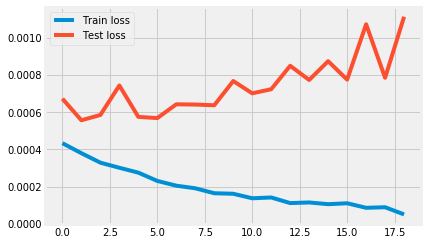

In [128]:
plt.plot(range(n_epochs-1),train_losses)
plt.plot(range(n_epochs-1),test_losses)
plt.legend(["Train loss","Test loss"])
plt.show()

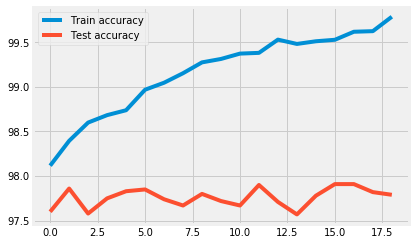

In [127]:
plt.plot(range(n_epochs-1),train_accuracy)
plt.plot(range(n_epochs-1),test_accuracy)
plt.legend(["Train accuracy","Test accuracy"])


plt.show()

Computing latent space projection...


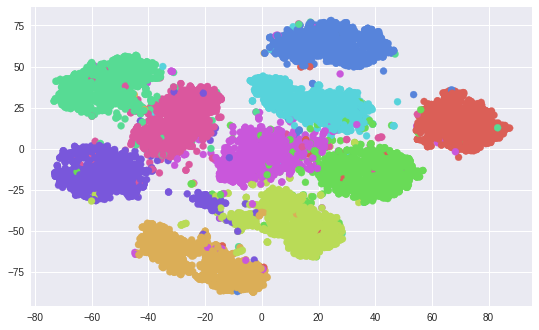

In [136]:
### Plot TSNE for latent space
# Show dataset images with T-sne projection of latent space encoding
import seaborn as sns
palette = np.array(sns.color_palette("hls", 10))
def visualize_tsne_of_input(X, labels, model, name):
    # Compute latent space representation
    print("Computing latent space projection...")
    
    X_encoded, _ = model.encode(X)
    
    # Compute t-SNE embedding of latent space
    tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
    X_tsne = tsne.fit_transform(X_encoded.data.detach().cpu())

    # Plot images according to t-sne embedding
    fig, ax = plt.subplots()
    plt.scatter(X_tsne[:,0], X_tsne[:,1],c=[palette[i] for i in labels])
    path = f'./traverse/latent_space_{epoch}.png' 
    fig.savefig(path, dpi=fig.dpi)
    
visualize_tsne_of_input(test_data[:10000].to(device),test_labels[:10000].to(device),model,epoch)